# K-means
Implemented from scratch or with SciKit-Learn.

For an algorithm description, see our more general notebook on Clustering.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [2]:
# Here are some standard data sets.
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Here are some nice colors for showing clusters
COLORS = np.array(["#377eb8","#ff7f00","#4daf4a","#f781bf","#a65628","#984ea3","#999999","#e41a1c","#dede00"])

## Implemented from scratch
To keep it simple, use only one feature i.e. one dimension.
The algorithm must slide the means left & right to find optimal.

Implementing our code, we compute and display SSE
but not that was not our stopping criteria; it was delta mean.

Testing our code, we found the initializers made a big difference.
The code often generated poor results when given bad initial values.

This code is designed for K=2. 
That simplifies the situation.
We only need to test two means for each point's cluster membership.
The distance calculation is scalar not vector.

This code is designed for #features=1.
That simplifies the situation.
Each distance from the mean is computed by 
simple subtraction along X axis.
For additional features, each point and mean would be a vector.
We would use element-wise subtraction to determine convergence, 
and norm=np.linalg.norm(diff)
i.e. sqrt of sum of squares of differences per dimension.

Our code can crash on divide by zero,
but this only happens with bad initial guesses 
outside the acutal (random) data range, such as
(0,0) or (0,1) or (1,2) or (100,200).
We saw fast convergence with parameters near the extremes
such as (10,50) .
We saw eventual convergence with means like 
(20,21) or (40,41) or (60,61).

In [3]:
def distance(p1,p2):
    # Compute the norm of the distance between points p1 and p2.
    # For single-feature data, all the norms are equivalent.
    # For Kmeans in higher dimensions, the L2 norm is used.
    # Althouth L1 is simply abs(p1-p2),
    # and sqrt of square is a wasteful identity op,
    # we'll use L2 to be pedantic.
    return np.sqrt((p1-p2)**2)
def is_closer(point,this_mean,that_mean):
    return distance(point,this_mean) < distance(point,that_mean)
def sse(vector,mean):
    err=vector-mean
    se=np.square(err)
    sse=sum(se)
    return int(sse)
def assign_clusters(mean1,mean2,data):
    clust1=np.asarray([x for x in data if is_closer(x,mean1,mean2)])
    clust2=np.asarray([x for x in data if is_closer(x,mean2,mean1)])
    print('Cluster sizes:',len(clust1),len(clust2))
    return clust1,clust2
def recompute_means(clust1,clust2):
    mean1=np.mean(clust1)
    mean2=np.mean(clust2)
    print('New means: %.2f %.2f' % (mean1,mean2) )
    return mean1,mean2
def compute_sse(clust1,clust2,mean1,mean2):
    sse1=sse(clust1,mean1)
    sse2=sse(clust2,mean2)
    print('Cluster SSE: %d %d' % (sse1,sse2) )
    print('Cluster stdev: %.2f %.2f' % (
        np.sqrt(sse1)/len(clust1),
          np.sqrt(sse2)/len(clust2)))  
    return sse1,sse2
def iterative_2_means_delta(mean1,mean2,data,delta):
    """Iterate till the means change by less than delta."""
    clust1,clust2=assign_clusters(mean1,mean2,data)
    sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
    prev_SSE = sse1 + sse2
    diff = None
    while diff is None or diff>delta:
        print()
        mean1,mean2=recompute_means(clust1,clust2)
        clust1,clust2=assign_clusters(mean1,mean2,data)
        sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
        this_SSE = sse1 + sse2
        diff = prev_SSE - this_SSE
        print('Diff:',diff,'Delta:',delta)
        prev_SSE = this_SSE
    return clust1,clust2

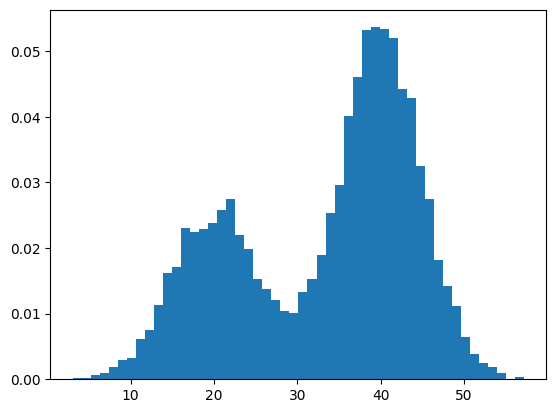

In [4]:
# Use data suggested by the Mastery site.
# Construct a bimodal from two Gaussian processes.
# Can K-means with K=2 reconstruct the 2 means?
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [5]:
# Choose not-quite-random initializers, k=2.
guess1 = 5
guess2 = 10
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
print('Initial means:',guess1,guess2)
new1,new2=iterative_2_means_delta(guess1,guess2,X,0.01)

Initial means: 5 10
Cluster sizes: 23 8977
Cluster SSE: 63 5914203
Cluster stdev: 0.35 0.27

New means: 6.12 33.38
Cluster sizes: 1421 7579
Cluster SSE: 143195 567441
Cluster stdev: 0.27 0.10
Diff: 5203630 Delta: 0.01

New means: 15.70 36.61
Cluster sizes: 2680 6320
Cluster SSE: 76843 237768
Cluster stdev: 0.10 0.08
Diff: 396025 Delta: 0.01

New means: 18.95 39.40
Cluster sizes: 2997 6003
Cluster SSE: 72021 143594
Cluster stdev: 0.09 0.06
Diff: 98996 Delta: 0.01

New means: 19.85 40.03
Cluster sizes: 3073 5927
Cluster SSE: 76665 132829
Cluster stdev: 0.09 0.06
Diff: 6121 Delta: 0.01

New means: 20.09 40.16
Cluster sizes: 3087 5913
Cluster SSE: 77869 131281
Cluster stdev: 0.09 0.06
Diff: 344 Delta: 0.01

New means: 20.14 40.19
Cluster sizes: 3089 5911
Cluster SSE: 78063 131076
Cluster stdev: 0.09 0.06
Diff: 11 Delta: 0.01

New means: 20.14 40.19
Cluster sizes: 3089 5911
Cluster SSE: 78063 131076
Cluster stdev: 0.09 0.06
Diff: 0 Delta: 0.01


## Implemented with SciKit-Learn

In [6]:
# Simple wrapper for Kmeans.
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.KMeans()  # default = 8
    if num_clusters is not None:
        alg = cluster.KMeans(num_clusters)  
    alg.fit(X)
    ypred = alg.labels_
    print('iterations',alg.n_iter_,',cluster centers:\n',alg.cluster_centers_)
    print('cluster assignments per point',alg.labels_)
    print('SSE (optionally weighted)',alg.inertia_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

### How many clusters?

iterations 9 ,cluster centers:
 [[0.79534914 0.7767049 ]
 [0.5314498  0.52658869]
 [0.78191059 0.2086025 ]
 [0.21577551 0.78487971]
 [0.23134547 0.20829077]]
cluster assignments per point [0 3 4 ... 3 1 1]
SSE (optionally weighted) 52.054175852921


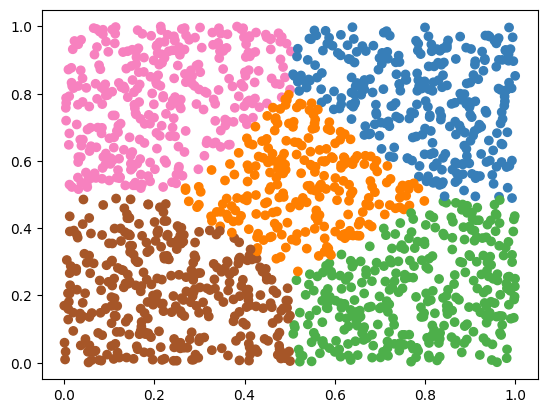

In [7]:
# When the data has no natural clusters,
# K-means might partion the data into equal size clusters.
# We will try K=5 and K=6 on same data.
make_clusters(no_structure,5)

iterations 11 ,cluster centers:
 [[0.50033986 0.75735263]
 [0.17120242 0.21849563]
 [0.84707043 0.2377632 ]
 [0.51442188 0.25895651]
 [0.15547951 0.7534227 ]
 [0.83703972 0.73903683]]
cluster assignments per point [5 4 1 ... 4 0 0]
SSE (optionally weighted) 44.02277239542798


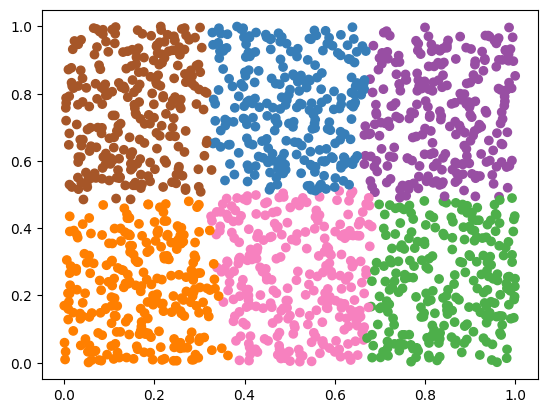

In [8]:
# Same as above with K=6.
make_clusters(no_structure,6)